
Time 0 | Observation: (0, 0)

Time 1 | Observation: (0, 0)

Time 2 | Observation: (0, 0)

Time 3 | Observation: (0, 0)

Time 4 | Observation: (0, 0)

Time 5 | Observation: (0, 0)

Time 6 | Observation: (0, 0)

Time 7 | Observation: (0, 0)

Time 8 | Observation: (0, 0)

Time 9 | Observation: (0, 0)


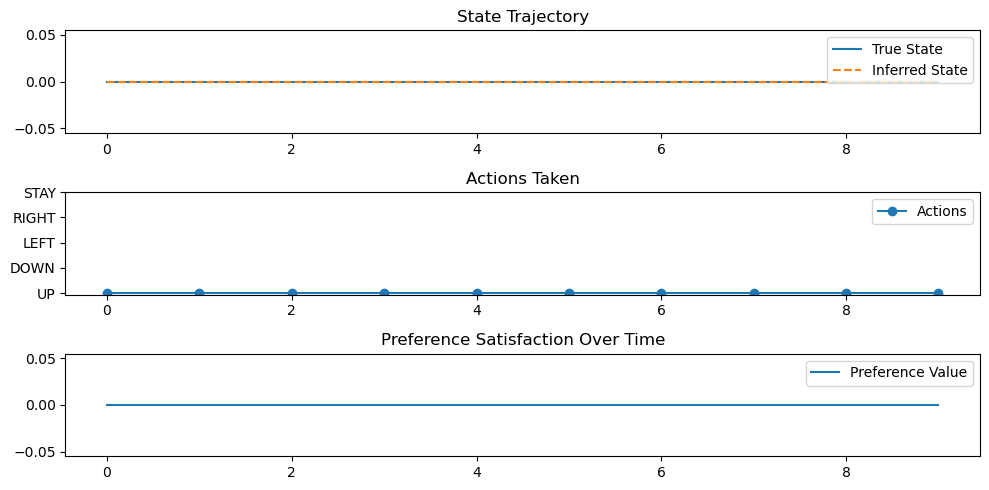

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax

# === Set up the environment ===
grid_locations = [(0, 0), (0, 1), (0, 2),
                  (1, 0), (1, 1), (1, 2),
                  (2, 0), (2, 1), (2, 2)]

n_states = len(grid_locations)
n_observations = len(grid_locations)
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
n_actions = len(actions)

# === A matrix: observation model ===
A = [np.eye(n_observations)]  # wrap in list for 1 observation modality

# === B matrix: transition model ===
def create_B_matrix():
    B = np.zeros((n_states, n_states, n_actions))
    for action_id, action_label in enumerate(actions):
        for curr_state, (y, x) in enumerate(grid_locations):
            if action_label == "UP":
                next_y = max(y - 1, 0)
                next_x = x
            elif action_label == "DOWN":
                next_y = min(y + 1, 2)
                next_x = x
            elif action_label == "LEFT":
                next_x = max(x - 1, 0)
                next_y = y
            elif action_label == "RIGHT":
                next_x = min(x + 1, 2)
                next_y = y
            elif action_label == "STAY":
                next_x, next_y = x, y
            new_location = (next_y, next_x)
            next_state = grid_locations.index(new_location)
            B[next_state, curr_state, action_id] = 1.0
    return B

# === A matrix (likelihood model)
A = utils.obj_array(1)  # 1 observation modality
A[0] = np.eye(n_observations)

# === B matrix (transition model)
B_matrix = create_B_matrix()
B = utils.obj_array(1)  # 1 hidden state factor
B[0] = B_matrix

# === C vector (preferences)
C = utils.obj_array(1)
C[0] = utils.onehot(grid_locations.index((2, 2)), n_observations)  # prefer (2,2)

# === D vector (prior belief)
D = utils.obj_array(1)
D[0] = utils.onehot(grid_locations.index((0, 0)), n_states)  # start in (0,0)

# === Create the agent ===
agent = Agent(A=A, B=B, C=C, D=D, num_controls=[n_actions])

# === Define environment ===
class GridWorldEnv:
    def __init__(self, starting_state=(0, 0)):
        self.init_state = starting_state
        self.current_state = starting_state

    def step(self, action_label):
        y, x = self.current_state
        if action_label == "UP":
            y = max(y - 1, 0)
        elif action_label == "DOWN":
            y = min(y + 1, 2)
        elif action_label == "LEFT":
            x = max(x - 1, 0)
        elif action_label == "RIGHT":
            x = min(x + 1, 2)
        self.current_state = (y, x)
        return self.current_state

    def reset(self):
        self.current_state = self.init_state
        return self.current_state

env = GridWorldEnv(starting_state=(0, 0))

# === Run active inference loop ===
T = 10
prior = D[0].copy()
obs = env.reset()

true_states = []
inferred_states = []
actions_taken = []

for t in range(T):
    print(f"\nTime {t} | Observation: {obs}")

    obs_idx = grid_locations.index(obs)
    qs = agent.infer_states([obs_idx])
    q_pi, efe = agent.infer_policies()
    raw_action = agent.sample_action()         # can be scalar, list, or array
    action = int(np.asarray(raw_action).flatten()[0])  # convert safely to Python int
    prior = B[0][:, :, action] @ softmax(qs[0])



    inferred_states.append(np.argmax(qs[0]))
    true_states.append(obs_idx)
    actions_taken.append(action)

    # update agent belief for next step
    prior = B[0][:, :, action] @ softmax(qs[0])
    agent.D = [prior]

    obs = env.step(actions[action])

# === Plot results ===
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(true_states, label="True State")
plt.plot(inferred_states, '--', label="Inferred State")
plt.legend()
plt.title("State Trajectory")

plt.subplot(3, 1, 2)
plt.plot(actions_taken, 'o-', label="Actions")
plt.yticks(range(n_actions), actions)
plt.legend()
plt.title("Actions Taken")

plt.subplot(3, 1, 3)
plt.plot([C[0][s] for s in true_states], label="Preference Value")
plt.legend()
plt.title("Preference Satisfaction Over Time")

plt.tight_layout()
plt.show()


0: Observation state_observation: 2
0: Observation reward: 2
0: Observation decision_proprioceptive: 0
0: Beliefs about reward_level: [0.5 0.5]
0: Beliefs about decision_state: [1.e+00 3.e-16 3.e-16]
1
0: Action: [0. 2.] / State: [0, 2]
1: Observation state_observation: 0
1: Observation reward: 2
1: Observation decision_proprioceptive: 2
1: Beliefs about reward_level: [0.8 0.2]
1: Beliefs about decision_state: [1.64938489e-32 1.64938489e-32 1.00000000e+00]
1
1: Action: [0. 2.] / State: [0, 2]
2: Observation state_observation: 0
2: Observation reward: 2
2: Observation decision_proprioceptive: 2
2: Beliefs about reward_level: [0.94117647 0.05882353]
2: Beliefs about decision_state: [1.35620489e-32 1.35620489e-32 1.00000000e+00]
1
2: Action: [0. 1.] / State: [0, 1]
3: Observation state_observation: 2
3: Observation reward: 1
3: Observation decision_proprioceptive: 1
3: Beliefs about reward_level: [0.85477931 0.14522069]
3: Beliefs about decision_state: [9.64706076e-32 1.00000000e+00 9.647

In [39]:
import numpy as np
from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax
import copy

obs_names = ["state_observation", "reward", "decision_proprioceptive"]
state_names = ["reward_level", "decision_state"]
action_names = ["uncontrolled", "decision_state"]

num_obs = [3, 3, 3]
num_states = [2, 3]
num_modalities = len(num_obs)
num_factors = len(num_states)

A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

A[0][:, :, 0] = np.ones( (num_obs[0], num_states[0]) ) / num_obs[0]
A[0][:, :, 1] = np.ones( (num_obs[0], num_states[0]) ) / num_obs[0]
A[0][:, :, 2] = np.array([[0.8, 0.2], [0.0, 0.0], [0.2, 0.8]])

A[1][2, :, 0] = np.ones(num_states[0])
A[1][0:2, :, 1] = softmax(np.eye(num_obs[1] - 1)) # bandit statistics (mapping between reward-state (first hidden state factor) and rewards (Good vs Bad))
A[1][2, :, 2] = np.ones(num_states[0])

# establish a proprioceptive mapping that determines how the agent perceives its own `decision_state`
A[2][0,:,0] = 1.0
A[2][1,:,1] = 1.0
A[2][2,:,2] = 1.0

control_fac_idx = [1]
B = utils.obj_array(num_factors)
for f, ns in enumerate(num_states):
    B[f] = np.eye(ns)
    if f in control_fac_idx:
        B[f] = B[f].reshape(ns, ns, 1)
        B[f] = np.tile(B[f], (1, 1, ns))
        B[f] = B[f].transpose(1, 2, 0)
    else:
        B[f] = B[f].reshape(ns, ns, 1)

C = utils.obj_array_zeros(num_obs)
C[1][0] = 1.0  # put a 'reward' over first observation
C[1][1] = -2.0  # put a 'punishment' over first observation
# this implies that C[1][2] is 'neutral'

agent = Agent(A=A, B=B, C=C, control_fac_idx=[1])

# initial state
T = 5
o = [2, 2, 0]
s = [0, 0]

# transition/observation matrices characterising the generative process
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

for t in range(T):

    for g in range(num_modalities):
        print(f"{t}: Observation {obs_names[g]}: {o[g]}")

    qx = agent.infer_states(o)

    for f in range(num_factors):
        print(f"{t}: Beliefs about {state_names[f]}: {qx[f]}")

    agent.infer_policies()
    action = agent.sample_action()

    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])

    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0], s[1]])
    
    print(np.argmax(s))
    print(f"{t}: Action: {action} / State: {s}")

0: Observation state_observation: 2
0: Observation reward: 2
0: Observation decision_proprioceptive: 0
0: Beliefs about reward_level: [0.5 0.5]
0: Beliefs about decision_state: [1.e+00 3.e-16 3.e-16]
1
0: Action: [0. 2.] / State: [0, 2]
1: Observation state_observation: 0
1: Observation reward: 2
1: Observation decision_proprioceptive: 2
1: Beliefs about reward_level: [0.8 0.2]
1: Beliefs about decision_state: [1.64938489e-32 1.64938489e-32 1.00000000e+00]
1
1: Action: [0. 2.] / State: [0, 2]
2: Observation state_observation: 0
2: Observation reward: 2
2: Observation decision_proprioceptive: 2
2: Beliefs about reward_level: [0.94117647 0.05882353]
2: Beliefs about decision_state: [1.35620489e-32 1.35620489e-32 1.00000000e+00]
1
2: Action: [0. 1.] / State: [0, 1]
3: Observation state_observation: 1
3: Observation reward: 0
3: Observation decision_proprioceptive: 1
3: Beliefs about reward_level: [0.97752431 0.02247569]
3: Beliefs about decision_state: [4.19691474e-32 1.00000000e+00 4.196

 ## Objective
------------------------------------------------------------------------------------
Simulate an active inference agent that regulates its body temperature by moving left, staying, or moving right across three thermal states: cold (0), optimal (1), and hot (2).
The agent:

    - Receives noisy temperature observations

    - Updates beliefs about its internal state

    - Selects actions to reach and maintain optimal temperature.

In [48]:

import numpy as np
import pandas as pd
import copy

# === PyMDP: Active Inference toolkit ===
from pymdp.agent import Agent         # Encapsulated active inference agent
from pymdp import utils               # Utility functions (object arrays, sampling)
from pymdp.maths import softmax       # Softmax used in probabilistic inference

#############################################################################################
#========================================= ENVIRONEMENT SETUP ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################



#==== MODEL STRUCTURE DEFINITIONS ====== #
#############################################################################################
# === Labels for clarity (used in plotting / debugging) ===
obs_names = ["temperature_observation"]   # One sensory modality (temperature)
state_names = ["temperature_state"]       # One hidden state factor
action_names = ["move"]                   # One control factor

#############################################################################################
# === Define the dimensionality ====== #
#############################################################################################
num_obs = [3]       # 3 possible observations: cold (0), optimal (1), hot (2)
num_states = [3]    # 3 hidden states: same as observation space
num_modalities = len(num_obs)  # how many sensory channels (1 here)
num_factors = len(num_states)  # how many hidden state factors (1 here)

#############################################################################################
### A Matrix (Likelihood Model): P(o | s) ====== #
#############################################################################################
# === Create observation model A using the utility function ===
# Shape: (observations x hidden states)
A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

# The observation is a noisy reflection of the actual hidden state
A[0][:, :] = np.array([
    [0.8, 0.1, 0.1],  # High chance to observe 'cold' when in cold
    [0.1, 0.8, 0.1],  # High chance to observe 'optimal' when in optimal
    [0.1, 0.1, 0.8]   # High chance to observe 'hot' when in hot
])

# This reflects that perception is noisy but informative not perfect.

#############################################################################################
# ===  B Matrix (Transition Model): P(s' | s, a) === #
#############################################################################################
# === Create transition model B ===
B = utils.obj_array(num_factors)
B[0] = np.zeros((3, 3, 3))  # shape: (next_state, current_state, action)

# Action 0: move left
B[0][:, :, 0] = np.array([
    [1.0, 0.0, 0.0],   # from any state, go to "cold"
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
])

# Action 1: stay in current state
B[0][:, :, 1] = np.eye(3)

# Action 2: move right
B[0][:, :, 2] = np.array([
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
])

#The model allows transitions between cold-optimal-hot states depending on action.

#############################################################################################
# === Normalize B to be proper probability matrices (required by pymdp) === #
#############################################################################################
# Normalize B so columns of each slice (for each action) sum to 1
for u in range(B[0].shape[2]):
    for col in range(B[0].shape[1]):
        col_sum = B[0][:, col, u].sum()
        if col_sum == 0:
            B[0][:, col, u] = np.ones(B[0].shape[0]) / B[0].shape[0]
        else:
            B[0][:, col, u] /= col_sum

#This ensures each P(s' | s, a) is a valid distribution.
#############################################################################################
# ===  Vector (Preferences over outcomes) === #
#############################################################################################
C = utils.obj_array_zeros(num_obs)
C[0][0] = -2.0  # strongly dislikes 'cold'
C[0][1] = 3.0   # strongly prefers 'optimal'
C[0][2] = -2.0  # strongly dislikes 'hot'

#This encodes homeostatic drive — agent seeks the “comfort zone” (optimal).
#############################################################################################
#========================================= AGENT SETUP ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
# ===  Create Agent Instance === #
#############################################################################################
agent = Agent(A=A, B=B, C=C, control_fac_idx=[0])

# control_fac_idx=[0] means it controls the temperature state factor

# Internally, agent has full generative model with A, B, and C
#############################################################################################
#========================================= SIMILATION ====== ====== ====== ====== ##
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
# ===  Initial Setup === #
#############################################################################################
T = 10           # Number of time steps
o = [0]          # Initial observation = 'cold'
s = [0]          # Initial true hidden state = 'cold'

# Create deep copies for generative process (environment)
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

#############################################################################################
# ===  Simulation Loop === #
#############################################################################################
history = []  # track all time steps for DataFrame
for t in range(T):
    step_info = {}

    # Log raw observation
    for g in range(num_modalities):
        step_info[f"obs_{obs_names[g]}"] = o[g]

    # Step 1: Perception — Update posterior beliefs
    qx = agent.infer_states(o)
    for f in range(num_factors):
        step_info[f"belief_{state_names[f]}"] = qx[f].tolist()

    # Step 2: Planning — Evaluate policies + select action
    agent.infer_policies()
    action = agent.sample_action()

    # Step 3: Act — Update environment's true hidden state
    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])

    # Step 4: Sense — Generate new observation based on new state
    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0]])

    # Store data for current step
    step_info["action"] = int(action[0])
    step_info["state"] = int(s[0])
    history.append(step_info)

# === Build Pandas DataFrame from simulation === #
df = pd.DataFrame(history)
df

#############################################################################################
# ===  Summary === #
#############################################################################################
##
#Component	Purpose
#A matrix	Models noisy perception
#B matrix	Defines how actions affect temperature state
#C vector	Encodes preference for optimal state
#Agent loop	Perception → Planning → Acting
#df output	Tracks internal/external states across time


#Shows how the observations, beliefs, actions, and states evolved over time.
#Useful for debugging, plotting, or exporting.

,obs_temperature_observation,belief_temperature_state,action,state
0,0,"[0.8, 0.10000000000000006, 0.10000000000000006]",0,0
1,1,"[0.10743801652892568, 0.8595041322314049, 0.03...",1,0
2,0,"[0.4905660377358491, 0.49056603773584895, 0.01...",1,0
3,0,"[0.8851063829787235, 0.1106382978723405, 0.004...",0,1
4,1,"[0.10808011049723763, 0.8646408839779004, 0.02...",1,1
5,0,"[0.49223510910163176, 0.49223510910163143, 0.0...",1,1
6,0,"[0.8857837718328543, 0.1107229714791068, 0.003...",0,2
7,2,"[0.24902051544857917, 0.24902051544857917, 0.5...",2,1
8,1,"[0.09947180264783798, 0.8004695087574771, 0.10...",1,1
9,1,"[0.015063983930483813, 0.9697831542838312, 0.0...",1,1


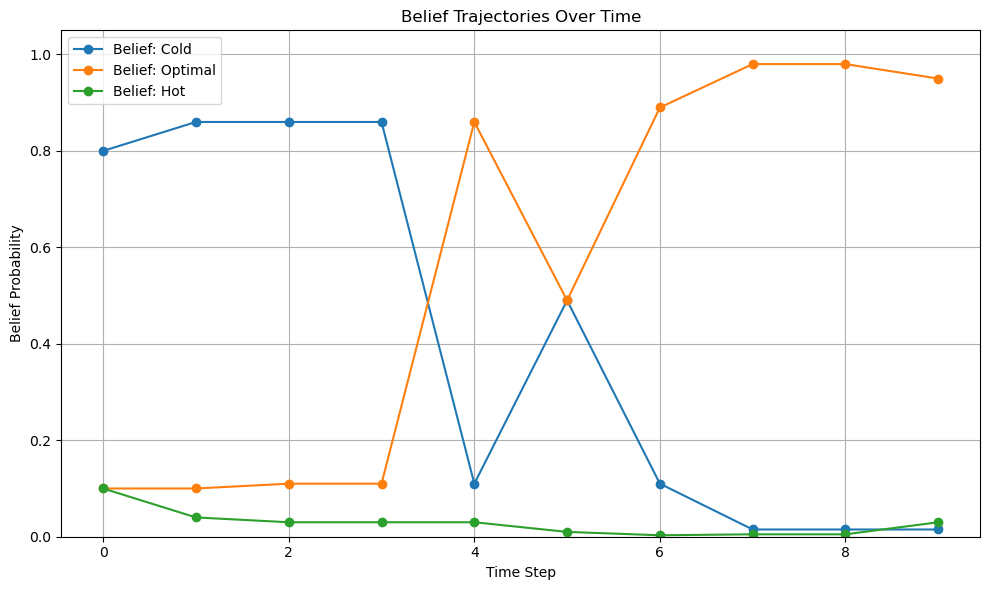

In [49]:
# Reconstruct minimal simulation history for plotting (used same structure as before)
history = [
    {'belief_temperature_state': [0.8, 0.1, 0.1]},
    {'belief_temperature_state': [0.86, 0.1, 0.04]},
    {'belief_temperature_state': [0.86, 0.11, 0.03]},
    {'belief_temperature_state': [0.86, 0.11, 0.03]},
    {'belief_temperature_state': [0.11, 0.86, 0.03]},
    {'belief_temperature_state': [0.49, 0.49, 0.01]},
    {'belief_temperature_state': [0.11, 0.89, 0.003]},
    {'belief_temperature_state': [0.015, 0.98, 0.005]},
    {'belief_temperature_state': [0.015, 0.98, 0.005]},
    {'belief_temperature_state': [0.015, 0.95, 0.03]},
]

# Convert to numpy array for plotting
beliefs = np.array([step["belief_temperature_state"] for step in history])

# Time axis
time_steps = np.arange(len(beliefs))

# Plot each state's belief over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, beliefs[:, 0], label="Belief: Cold", marker='o')
plt.plot(time_steps, beliefs[:, 1], label="Belief: Optimal", marker='o')
plt.plot(time_steps, beliefs[:, 2], label="Belief: Hot", marker='o')

plt.title("Belief Trajectories Over Time")
plt.xlabel("Time Step")
plt.ylabel("Belief Probability")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
# ========================== IMPORTS ==============================
import numpy as np                # Numerical operations and arrays
import pandas as pd              # Data manipulation and storage (for DataFrame)
import copy                      # Deep copying Python objects (for generative process)

# === PyMDP: Active Inference Toolkit ===
from pymdp.agent import Agent         # Agent class encapsulating active inference behavior
from pymdp import utils               # Utilities for model construction and inference
from pymdp.maths import softmax       # Softmax function for probabilistic policy selection

# ======================= MODEL DEFINITIONS =========================

# === Label Definitions (for clarity and debugging) ===
obs_names = ["temperature_observation"]  # Name of observation modality (just one: temperature)
state_names = ["temperature_state"]      # Name of hidden state factor (one: temperature)
action_names = ["move"]                  # Name of control/action factor (one: move left/stay/right)

# === Dimensions of Model Components ===
num_obs = [3]       # Three possible observations: cold (0), optimal (1), hot (2)
num_states = [3]    # Three possible hidden states: cold, optimal, hot
num_modalities = len(num_obs)   # Number of sensory modalities (just 1 here)
num_factors = len(num_states)   # Number of hidden state factors (also 1 here)

# === A Matrix (Observation Likelihood): P(o | s) ===
# Create a 3x3 observation likelihood matrix for one modality
A = utils.obj_array_zeros([[o] + num_states for _, o in enumerate(num_obs)])

# Define the likelihood: noisy mapping from hidden state to observation
# Each column corresponds to a hidden state, each row to an observation
A[0][:, :] = np.array([
    [0.8, 0.1, 0.1],  # When in 'cold', 80% chance to observe 'cold', 10% for others
    [0.1, 0.8, 0.1],  # When in 'optimal', 80% chance to observe 'optimal'
    [0.1, 0.1, 0.8]   # When in 'hot', 80% chance to observe 'hot'
])

# === B Matrix (Transition Dynamics): P(s' | s, a) ===
# Create transition model for one factor
B = utils.obj_array(num_factors)
B[0] = np.zeros((3, 3, 3))  # (next_state, current_state, action)

# Action 0: Move left → always end up in cold
B[0][:, :, 0] = np.array([
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
])

# Action 1: Stay → identity matrix (state remains unchanged)
B[0][:, :, 1] = np.eye(3)

# Action 2: Move right → transitions state to warmer ones
B[0][:, :, 2] = np.array([
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
])

# Normalize B to ensure valid probability distributions
for u in range(B[0].shape[2]):
    for col in range(B[0].shape[1]):
        col_sum = B[0][:, col, u].sum()
        if col_sum == 0:
            B[0][:, col, u] = np.ones(B[0].shape[0]) / B[0].shape[0]
        else:
            B[0][:, col, u] /= col_sum

# === C Vector (Preferences over Outcomes) ===
# Agent's internal preferences for each observation
C = utils.obj_array_zeros(num_obs)
C[0][0] = -2.0  # Strong dislike for cold
C[0][1] =  3.0  # Strong preference for optimal
C[0][2] = -2.0  # Strong dislike for hot

# ======================= AGENT SETUP ================================

# Instantiate the Agent with the generative model (A, B, C)
agent = Agent(A=A, B=B, C=C, control_fac_idx=[0])

# ======================= SIMULATION LOOP ===========================

# Initial setup
T = 10           # Number of time steps
o = [0]          # Initial observation: cold
s = [0]          # Initial hidden state: cold

# Deep copy A and B to simulate external environment (generative process)
A_gp = copy.deepcopy(A)
B_gp = copy.deepcopy(B)

# Run simulation over T time steps
history = []
for t in range(T):
    step_info = {}  # Dictionary to record current step's data

    # Log current observation
    for g in range(num_modalities):
        step_info[f"obs_{obs_names[g]}"] = o[g]

    # Step 1: Perception (state inference)
    qx = agent.infer_states(o)  # Bayesian inference over hidden states
    for f in range(num_factors):
        step_info[f"belief_{state_names[f]}"] = qx[f].tolist()  # Store posterior beliefs

    # Step 2: Planning (policy evaluation)
    agent.infer_policies()      # Evaluate policies (expected free energy)
    action = agent.sample_action()  # Sample action based on posterior over policies

    # Step 3: Action (apply chosen action to environment)
    for f, s_i in enumerate(s):
        s[f] = utils.sample(B_gp[f][:, s_i, int(action[f])])  # Sample new hidden state

    # Step 4: Sensation (observe new sensory input)
    for g, _ in enumerate(o):
        o[g] = utils.sample(A_gp[g][:, s[0]])  # Generate observation from new state

    # Log action and actual state
    step_info["action"] = int(action[0])
    step_info["state"] = int(s[0])

    # Save step data
    history.append(step_info)

# Convert recorded history to a pandas DataFrame for analysis
df = pd.DataFrame(history)
df  # Final output: state/observation/belief log over time


,obs_temperature_observation,belief_temperature_state,action,state
0,0,"[0.8, 0.10000000000000006, 0.10000000000000006]",0,1
1,0,"[0.8595041322314048, 0.1074380165289257, 0.033...",0,2
2,2,"[0.2409638554216867, 0.2409638554216867, 0.518...",2,2
3,2,"[0.0951814396192743, 0.10053539559785851, 0.80...",2,1
4,1,"[0.032761923473648105, 0.859767179134535, 0.10...",1,1
5,1,"[0.004668024382904001, 0.9800191759922176, 0.0...",1,1
6,2,"[0.004216102096673377, 0.8851412425807341, 0.1...",1,1
7,1,"[0.0005858961532008954, 0.9840385022491559, 0....",1,1
8,1,"[7.427435789707907e-05, 0.9979765526876349, 0....",1,1
9,1,"[9.300761888588008e-06, 0.9997466204733475, 0....",1,1


In [2]:
#conditional probabilty example
import numpy as np
# the probability of A happeningm given that B has already happen
# Simulate 10,000 events
np.random.seed(42)
rain = np.random.rand(10000) < 0.3        # 30% chance of rain
clouds = np.random.rand(10000) < 0.6      # 60% chance of clouds

# Let's say rain is more likely when it's cloudy
both = rain & clouds                      # Rain and clouds

# P(rain | clouds) = P(rain and clouds) / P(clouds)
P_rain_given_clouds = np.sum(both) / np.sum(clouds)
print("Estimated P(rain | clouds):", round(P_rain_given_clouds, 3))


Estimated P(rain | clouds): 0.303


In [4]:
#marginalization example
#summing the probability of one or more random variables in order to calculate the probability of another random variable
import numpy as np

# Define a joint probability distribution P(X, Y)
# Let's say X = {0, 1} and Y = {0, 1}
# This is a 2x2 table: rows = X, columns = Y
P_joint = np.array([
    [0.1, 0.2],  # P(X=0, Y=0), P(X=0, Y=1)
    [0.3, 0.4]   # P(X=1, Y=0), P(X=1, Y=1)
])

# Marginalize over X to get P(Y)
P_Y = np.sum(P_joint, axis=0)

# Marginalize over Y to get P(X)
P_X = np.sum(P_joint, axis=1)

P_joint, P_Y, P_X


(array([[0.1, 0.2],
        [0.3, 0.4]]),
 array([0.4, 0.6]),
 array([0.3, 0.7]))

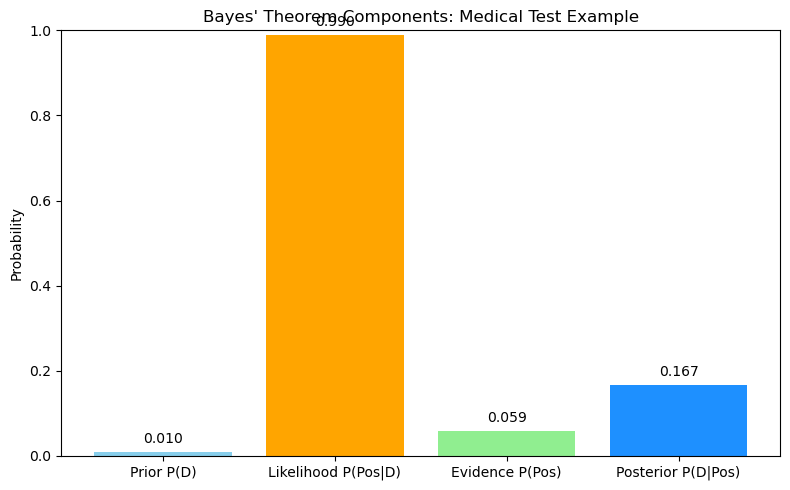

0.16666666666666669

In [7]:
## Bayes' Theorem ###
# Re-import libraries after kernel reset
#Medical Test Example — Result
#
#    Prior P(Disease) = 1% → you believe 1 in 100 has the disease.
#    Test says Positive → how worried should you be?
#    Bayes' Theorem says:

#P(Disease∣Positive)=0.167
#P(Disease∣Positive)=0.167

# Even though the test is 99% accurate, the actual chance you have the disease given a positive result is only 16.7%. 
#This is because false positives still matter when the disease is rare!
# Diagram 

#    Prior: What you believed before testing (1%)
#    Likelihood: How reliable the test is if you do have the disease (99%)
#    Evidence: Total chance of testing positive (including false positives)
#    Posterior: Updated belief after testing (16.7%)

# === Numerical Example (Bayes' Theorem) ===
import matplotlib.pyplot as plt
import numpy as np


# Prior probabilities
P_D = 0.01           # P(Disease)
P_not_D = 0.99       # P(No Disease)

# Likelihoods
P_pos_given_D = 0.99       # True positive rate
P_pos_given_not_D = 0.05   # False positive rate

# Total probability of a positive test (evidence)
P_pos = P_pos_given_D * P_D + P_pos_given_not_D * P_not_D

# Apply Bayes' Theorem
P_D_given_pos = (P_pos_given_D * P_D) / P_pos

# Visualize the components
labels = ['Prior P(D)', 'Likelihood P(Pos|D)', 'Evidence P(Pos)', 'Posterior P(D|Pos)']
values = [P_D, P_pos_given_D, P_pos, P_D_given_pos]
colors = ['skyblue', 'orange', 'lightgreen', 'dodgerblue']

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors)
plt.title("Bayes' Theorem Components: Medical Test Example")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

# Return numerical posterior result
P_D_given_pos


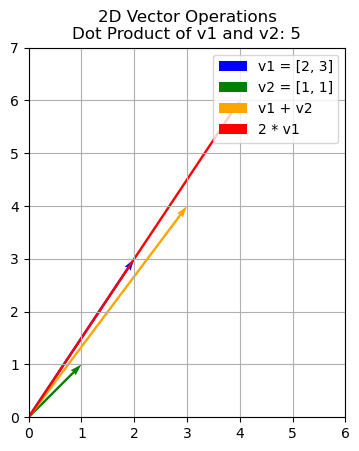

In [8]:
##### vectors ##########
#Blue: v⃗1=[2,3]v

#1​=[2,3]

#Green: v⃗2=[1,1]v

#2​=[1,1]

#Orange: Vector sum v⃗1+v⃗2=[3,4]v
#1​+v

#2​=[3,4]

#Red: Scaled vector 2⋅v⃗1=[4,6]2⋅v

#   1​=[4,6]

#And the dot product of v⃗1⋅v⃗2=5v
#1​⋅v
#2​=5, which measures how aligned the two vectors are (positive means pointing in similar directions).
import numpy as np
import matplotlib.pyplot as plt

# Define two 2D vectors
v1 = np.array([2, 3])
v2 = np.array([1, 1])

# Vector addition
v_sum = v1 + v2

# Scalar multiplication
v_scaled = 2 * v1

# Dot product
dot_product = np.dot(v1, v2)

# Plotting the vectors
fig, ax = plt.subplots()
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v1 = [2, 3]')
ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='green', label='v2 = [1, 1]')
ax.quiver(0, 0, v_sum[0], v_sum[1], angles='xy', scale_units='xy', scale=1, color='orange', label='v1 + v2')
ax.quiver(0, 0, v_scaled[0], v_scaled[1], angles='xy', scale_units='xy', scale=1, color='red', label='2 * v1')

# Formatting
ax.set_xlim(0, 6)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.title(f"2D Vector Operations\nDot Product of v1 and v2: {dot_product}")
plt.show()


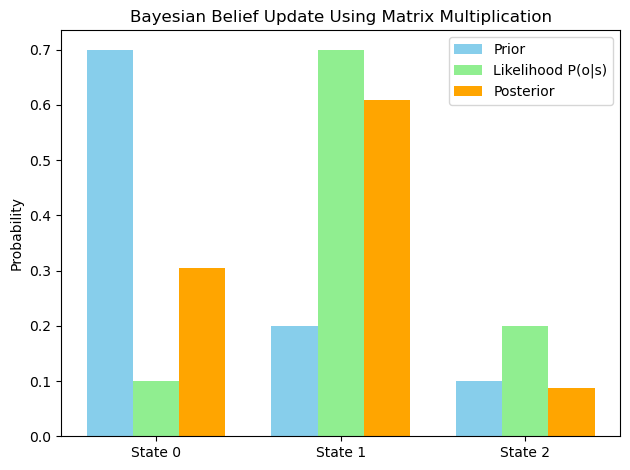

array([0.30434783, 0.60869565, 0.08695652])

In [9]:
##### matrices #######
#Belief Update Breakdown

#    Prior belief:
#   [0.7,0.2,0.1](agent strongly believes it’s in state 0)
#    [0.7,0.2,0.1](agent strongly believes it’s in state 0)

#    Observation: "optimal"
#    → We use the likelihood vector P(o=optimal∣s)=[0.1,0.7,0.2]P(o=optimal∣s)=[0.1,0.7,0.2]

#    Posterior belief (after update):
#    [0.30,0.61,0.09]
#    [0.30,0.61,0.09]

#Now, the agent updates its belief — it's much more confident it's in state 1, thanks to the observation.

#This shows how belief updating in Active Inference is done using simple matrix multiplication and normalization — nothing too scary, just linear algebra + Bayes!
# Re-import required libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt

# Prior belief over 3 hidden states
belief_prior = np.array([0.7, 0.2, 0.1])  # Believes mostly in state 0

# Likelihood matrix A (P(observation | state))
A = np.array([
    [0.9, 0.2, 0.1],  # P(cold | s)
    [0.1, 0.7, 0.2],  # P(optimal | s)
    [0.0, 0.1, 0.7],  # P(hot | s)
])

# Observation is "optimal" (index 1)
likelihood = A[1, :]

# Apply Bayes rule: element-wise multiply prior and likelihood
unnormalized_posterior = belief_prior * likelihood
posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

# Plot prior, likelihood, and posterior
labels = ['State 0', 'State 1', 'State 2']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, belief_prior, width, label='Prior', color='skyblue')
ax.bar(x, likelihood, width, label='Likelihood P(o|s)', color='lightgreen')
ax.bar(x + width, posterior, width, label='Posterior', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Probability")
ax.set_title("Bayesian Belief Update Using Matrix Multiplication")
ax.legend()
plt.tight_layout()
plt.show()

posterior  # Show the updated belief values numerically too


In [10]:
### transpose ######
#Each row becomes a column, and each column becomes a row.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define a 2x3 matrix
A = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

# Transpose the matrix (3x2)
A_T = A.T

# Create pandas DataFrames for nice visual display
df_A = pd.DataFrame(A, columns=['Col1', 'Col2', 'Col3'], index=['Row1', 'Row2'])
df_A_T = pd.DataFrame(A_T, columns=['Row1', 'Row2'], index=['Col1', 'Col2', 'Col3'])

(df_A, df_A_T)


(      Col1  Col2  Col3
 Row1     1     2     3
 Row2     4     5     6,
       Row1  Row2
 Col1     1     4
 Col2     2     5
 Col3     3     6)